## Prior sensitivity analysis

Objective to see how sensitive is the model to random walk prior specification. That is, we define the probability of a connect move as 

$$ P(connect) = \frac{e^{-\rho}}{1+e^{-\rho}}, \quad \rho \in (-\infty, \infty) $$

In this setup, the Metropolis--Hasting prior raito is 

$$ P(connect)/P(disconnect) = e^{-\rho} $$


In [1]:
%load_ext autoreload
%autoreload 2
import sys
import time
sys.path.append('..')
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

import parallelDG.graph.graph as glib
import parallelDG.graph.decomposable as dlib
import parallelDG.mh_parallel as pdg
import parallelDG.graph.junction_tree as jtlib
from networkx.drawing.nx_pydot import graphviz_layout
import itertools
import parallelDG.auxiliary_functions as auxlib

sns.set_style("whitegrid")
options = {
    "font_size": 12,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}

    
def dedup_traj(traj): 
    print('length traj {}'.format(len(traj)))
    new_lst = []
    for i in traj:
        if not new_lst or new_lst[-1] != i:
            new_lst.append(i)
    return new_lst
    

## Testing Jump prior sensitivity

* alternate the jump proir threshold from 0 t 1

## Generate decomopsable table

In [2]:
graph_size = 7

In [ ]:
tic = time.time()
all_edges = auxlib.edges_powerset(graph_size)
all_graphs_of_size_p = list(auxlib.powerset(all_edges))
decomp_table = auxlib.filter_decomposable_graphs(all_graphs_of_size_p, graph_size)
print("#.all graph {}, #decomp graphs {} of {} nodes".format(len(all_graphs_of_size_p), 
                                                              len(decomp_table), 
                                                              graph_size))
toc = time.time()
print('time took {:.2f}sec'.format(toc - tic))

In [11]:
#auxlib.save_decomposable_table(decomp_table, '7_vertex_decomposable_graphs.csv')
decomp_table = pd.read_csv('7_vertex_decomposable_graphs.csv')

## Prior sensitivity analysis single move

In [12]:
def prior_sensitivity(rho = 0.1, single_move = True):
    print('rho {}'.format(rho))
    traj = pdg.sample_trajectory_uniform(n_samples =1000000, 
                                     randomize = 100,
                                     graph_prior = ['jumppenalty', rho],
                                     graph_size  = graph_size, 
                                     single_move= single_move,
                                     cache = None)
    traj.set_graph_trajectories(index_type = 'mcmc_subindex')
    #traj.trajectory = dedup_traj(traj.trajectory)
    print('length traj {}'.format(len(traj.trajectory)))
    graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)
    df = auxlib.join_with_decom_table(graph_table, decomp_table)
    df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
    df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
    df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'] - 2.0))
    def normalize(x):
        "plotting the probability density function"
        x = x.values
        a = float(np.sum(x))
        b = np.cumsum(x)
        return b/a
    result = {
        'rho': rho, 
        'single_move': single_move,
        'n_jt' : df['n_jt'].values,
        'count': normalize(df['count'].fillna(0)), 
        'count_t': normalize(df['count_t']),
        'count_jt': normalize(df['count_jt'])
    }
    return result

In [5]:
rho = [-0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
#rho = [0.0, 0.2, 0.4, 0.6]
res = [prior_sensitivity(rho = r) for r in rho]

Metropolis-Hastings - single-move:   0%|          | 1429/999999 [00:00<01:09, 14285.14it/s]

rho -0.2


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:17<00:00, 12959.60it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 12953.51updates/sec
Acceptance rate 0.5934
mcmc_subindex
length traj 1000000


Metropolis-Hastings - single-move:   0%|          | 1145/999999 [00:00<01:27, 11444.85it/s]

rho 0.0


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:22<00:00, 12183.70it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 12177.68updates/sec
Acceptance rate 0.7089
mcmc_subindex
length traj 1000000


Metropolis-Hastings - single-move:   0%|          | 890/999999 [00:00<01:52, 8899.03it/s]

rho 0.2


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:21<00:00, 12340.65it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 12331.35updates/sec
Acceptance rate 0.7680
mcmc_subindex
length traj 1000000


Metropolis-Hastings - single-move:   0%|          | 664/999999 [00:00<02:30, 6636.02it/s]

rho 0.4


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [02:21<00:00, 7086.24it/s] 


Total of 1000000 updates, for an average of 1.00 per iteration or 7081.79updates/sec
Acceptance rate 0.7743
mcmc_subindex
length traj 1000000


Metropolis-Hastings - single-move:   0%|          | 625/999999 [00:00<02:39, 6246.25it/s]

rho 0.6


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:23<00:00, 11978.92it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 11964.40updates/sec
Acceptance rate 0.7323
mcmc_subindex
length traj 1000000


Metropolis-Hastings - single-move:   0%|          | 665/999999 [00:00<02:30, 6647.74it/s]

rho 0.8


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:20<00:00, 12499.43it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 12480.61updates/sec
Acceptance rate 0.6618
mcmc_subindex
length traj 1000000


Metropolis-Hastings - single-move:   0%|          | 450/999999 [00:00<03:42, 4499.82it/s]

rho 1.0


Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [01:17<00:00, 12867.87it/s]


Total of 1000000 updates, for an average of 1.00 per iteration or 12847.81updates/sec
Acceptance rate 0.5758
mcmc_subindex
length traj 1000000


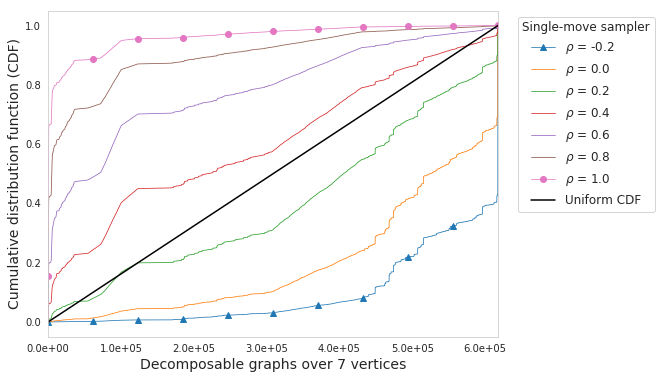

In [7]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))

for i, run in enumerate(res): 
    marker = None
    ct = run['count']
    color = plt.get_cmap('tab10')(i)
    if i == 0:
        marker = '^'
    if i == len(res) - 1: 
        marker = 'o'
    ax = pd.Series(ct).plot(linestyle= 'solid',
                            marker = marker,
                            markevery = len(ct) // 10,
                            linewidth = 0.75, 
                            color= color,
                            label= r'$\rho$ = {}'.format(run['rho']))

N = len(ct)
plt.plot([0, N], [0, 1], color='black', linewidth=1.5, label='Uniform CDF')
plt.grid(False)


ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1e}'.format(x)))
plt.xlabel('Decomposable graphs over 7 vertices',fontsize=14)
plt.ylabel('Cumulative distribution function (CDF)', fontsize=14)

# Place the legend outside the plot area on the right side
legend = plt.legend(title='Single-move sampler', 
                    fontsize='large', 
                    bbox_to_anchor=(1.03, 1), 
                    loc='upper left')

plt.setp(legend.get_title(), fontsize='large')

# Adjust the right margin to make room for the legend
plt.subplots_adjust(right=0.75)

plt.savefig('prior_sensitivity_single_move.pdf', format='pdf')
plt.show()


### Parallel move

In [4]:
def prior_sensitivity(rho = 0.1, single_move = True):
    print('rho {}'.format(rho))
    traj = pdg.sample_trajectory_uniform(n_samples =1000000, 
                                     randomize = 100,
                                     graph_prior = ['jumppenalty', rho],
                                     graph_size  = graph_size, 
                                     single_move= single_move,
                                     cache = None)
    traj.set_graph_trajectories(index_type = 'mcmc_subindex')
    #traj.trajectory = dedup_traj(traj.trajectory)
    print('length traj {}'.format(len(traj.trajectory)))
    graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)
    df = auxlib.join_with_decom_table(graph_table, decomp_table)
    df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
    df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
    df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'] - 2.0))
    def normalize(x):
        "plotting the probability density function"
        x = x.values
        a = float(np.sum(x))
        b = np.cumsum(x)
        return b/a
    result = {
        'rho': rho, 
        'single_move': single_move,
        'n_jt' : df['n_jt'].values,
        'count_serial': normalize(df['count'].fillna(0)), 
        'count_t_serial': normalize(df['count_t']),
        'count_jt_serial': normalize(df['count_jt'])
    }
    traj.set_graph_trajectories()
    #traj.trajectory = dedup_traj(traj.trajectory)
    print('length traj {}'.format(len(traj.trajectory)))
    graph_table = auxlib.count_decomposable_graphs_trajectories(traj.trajectory)
    df['count'] = 0.0
    df = auxlib.join_with_decom_table(graph_table, decomp_table)
    df['count_jt'] = df['count'].fillna(0).values/df['n_jt'].values
    df['L'] = np.clip(graph_size - df['n_clqs'], 1.0, None)
    df['count_t'] = df['count'].fillna(0).values/(df['L'].values ** (df['L'] - 2.0))
    result.update({
        'count': normalize(df['count'].fillna(0)), 
        'count_t': normalize(df['count_t']),
        'count_jt': normalize(df['count_jt'])
    }
    )
    return result

In [5]:
rho = [-0.6, -0.2, 0.0, 0.2, 0.4, 0.8]
res = [prior_sensitivity(rho = r, single_move=False) for r in rho]

Metropolis-Hastings - parallel moves:   0%|          | 857/999999 [00:00<01:56, 8565.37it/s]

rho -0.6


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:50<00:00, 9042.44it/s] 


Total of 2706862 updates, for an average of 2.71 per iteration or 24469.49updates/sec
Acceptance rate 0.7002
mcmc_subindex
length traj 2706862
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 710/999999 [00:00<02:20, 7095.17it/s]

rho -0.2


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:50<00:00, 9063.40it/s] 


Total of 2356735 updates, for an average of 2.36 per iteration or 21351.12updates/sec
Acceptance rate 0.8849
mcmc_subindex
length traj 2356735
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 0/999999 [00:00<?, ?it/s]

rho 0.0


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:20<00:00, 12414.88it/s]


Total of 2137007 updates, for an average of 2.14 per iteration or 26499.02updates/sec
Acceptance rate 0.9838
mcmc_subindex
length traj 2137007
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 1112/999999 [00:00<01:29, 11116.88it/s]

rho 0.2


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:29<00:00, 11126.57it/s]


Total of 1915532 updates, for an average of 1.92 per iteration or 21291.71updates/sec
Acceptance rate 0.8870
mcmc_subindex
length traj 1915532
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 1255/999999 [00:00<01:36, 10328.79it/s]

rho 0.4


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [00:56<00:00, 17605.77it/s]


Total of 1734470 updates, for an average of 1.73 per iteration or 30496.48updates/sec
Acceptance rate 0.7937
mcmc_subindex
length traj 1734470
mcmc_index
length traj 1000000


Metropolis-Hastings - parallel moves:   0%|          | 1279/999999 [00:00<01:18, 12781.54it/s]

rho 0.8


Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [00:48<00:00, 20784.52it/s]


Total of 1439986 updates, for an average of 1.44 per iteration or 29873.34updates/sec
Acceptance rate 0.6198
mcmc_subindex
length traj 1439986
mcmc_index
length traj 1000000


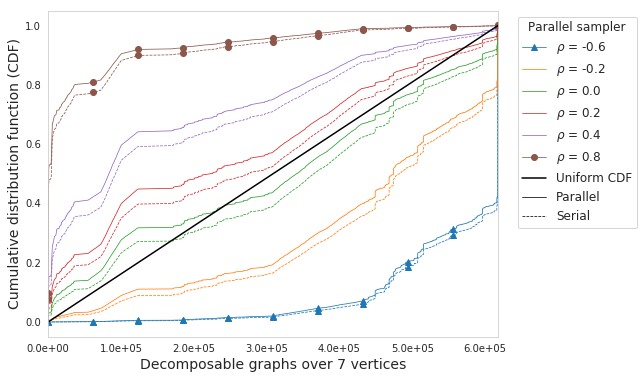

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.lines as mlines

plt.figure(figsize=(10, 6))

for i, run in enumerate(res):
    marker = None
    if i == 0:
        marker = '^'
    if i == len(res) - 1: 
        marker = 'o'
    ct = run['count']
    ct_serial = run['count_serial']
    color = plt.get_cmap('tab10')(i)
    ax = pd.Series(ct).plot(linestyle='solid', 
                            linewidth = 0.75,
                            marker = marker,
                            markevery = len(ct) // 10,
                            color= color,
                            label= r'$\rho$ = {}'.format(run['rho']))
    ax = pd.Series(ct_serial).plot(linestyle='dashed',
                                   marker = marker,
                                   markevery = len(ct_serial) // 10,
                                   linewidth = 0.75, 
                                   color= color, label='')

N = len(ct)
plt.plot([0, N], [0, 1], color='black', linewidth=1.5, label='Uniform CDF')
plt.grid(False)



ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:0.1e}'.format(x)))
plt.xlabel('Decomposable graphs over 7 vertices',fontsize=14)
plt.ylabel('Cumulative distribution function (CDF)', fontsize=14)


# Create custom lines
parallel_line = mlines.Line2D([], [], color='black', linewidth=0.75, label='Parallel')
serial_line = mlines.Line2D([], [], color='black', linestyle='dashed', linewidth=0.75, label='Serial')

# Get the handles and labels from the current axes
handles, labels = plt.gca().get_legend_handles_labels()

# Add the custom lines to the handles and labels
handles.extend([parallel_line, serial_line])
labels.extend(['Parallel', 'Serial'])


# Place the legend outside the plot area on the right side
legend = plt.legend(handles, labels,
                    title='Parallel sampler', 
                    fontsize='large', 
                    bbox_to_anchor=(1.03, 1), 
                    loc='upper left')
plt.setp(legend.get_title(), fontsize='large')

# Adjust the right margin to make room for the legend
plt.subplots_adjust(right=0.75)

plt.savefig('prior_sensitivity_parallel.pdf', format='pdf')
plt.show()


## Time estimations

In [3]:
def run_model(p):
    delta = 5
    n_samples = 100000
    randomize  = 100
    graph_prior = ['uniform']
    tic = time.time()
    print(p)
    traj = pdg.traj = pdg.sample_trajectory_uniform(
                                    n_samples=n_samples,
                                     randomize=randomize, 
                                     graph_size  = p,
                                     graph_prior = graph_prior,
                                     delta = delta,
                                     singe_move = False)
    toc = time.time()
    print('Time taken {:.2f}sec'.format(toc-tic))
    traj_single = pdg.traj = pdg.sample_trajectory_uniform(
                                     n_samples=n_samples,
                                     randomize=randomize,
                                     graph_size  = p,
                                     graph_prior = graph_prior,
                                     delta = delta, 
                                     single_move = True)
    return (p, 1000 * traj.time/traj.n_updates, 1000 * traj.time/n_samples, 1000 * traj_single.time/n_samples)

In [7]:
p_range = [10, 50, 100, 150] #,200, 300, 500]
res = [run_model(p) for p in p_range]

Metropolis-Hastings - parallel moves:   1%|▏         | 1331/99999 [00:00<00:08, 11270.09it/s]

10


Metropolis-Hastings - single-move:   2%|▏         | 1994/99999 [00:00<00:04, 19938.21it/s]

Total of 243702 updates, for an average of 2.44 per iteration or 32514.49updates/sec
Acceptance rate 0.9868
Time taken 7.50sec


Metropolis-Hastings - parallel moves:   1%|          | 821/99999 [00:00<00:12, 8199.84it/s]

Total of 100000 updates, for an average of 1.00 per iteration or 19376.06updates/sec
Acceptance rate 0.8844
50


Metropolis-Hastings - single-move:   1%|          | 1164/99999 [00:00<00:08, 11639.21it/s]

Total of 535470 updates, for an average of 5.35 per iteration or 24622.23updates/sec
Acceptance rate 0.9948
Time taken 21.80sec


Metropolis-Hastings - parallel moves:   1%|          | 500/99999 [00:00<00:21, 4720.68it/s]

Total of 100000 updates, for an average of 1.00 per iteration or 13289.20updates/sec
Acceptance rate 0.8801
100


Metropolis-Hastings - single-move:   0%|          | 469/99999 [00:00<00:21, 4689.71it/s]

Total of 813677 updates, for an average of 8.14 per iteration or 13097.75updates/sec
Acceptance rate 0.9967
Time taken 62.23sec


Metropolis-Hastings - single-move: 100%|██████████| 99999/99999 [00:24<00:00, 4138.24it/s]


Total of 100000 updates, for an average of 1.00 per iteration or 4137.42updates/sec
Acceptance rate 0.8842
150


Metropolis-Hastings - single-move:   0%|          | 216/99999 [00:00<00:46, 2159.46it/s]

Total of 1095401 updates, for an average of 10.95 per iteration or 10082.91updates/sec
Acceptance rate 0.9974
Time taken 108.96sec


Metropolis-Hastings - single-move: 100%|██████████| 99999/99999 [00:45<00:00, 2175.55it/s]

Total of 100000 updates, for an average of 1.00 per iteration or 2175.34updates/sec
Acceptance rate 0.8866


In [8]:
df = pd.DataFrame(res, columns=['n', 'serial', 'parallel', 'single_move'])
df

,n,serial,parallel,single_move
0,10,0.030756,0.074952,0.051610
1,50,0.040614,0.217474,0.075249
2,100,0.076349,0.621234,0.241697
3,150,0.099178,1.086394,0.459699


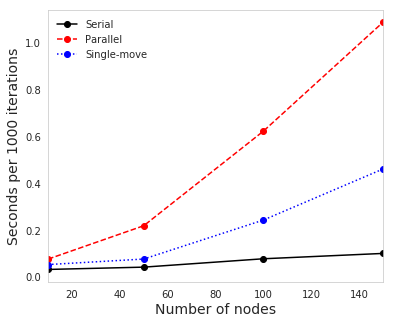

In [9]:
df.plot(x='n', 
        marker='o', 
        color=['black','red', 'blue' ], 
        style = ['-', '--', ':'], 
        figsize=(6,5))
plt.ylabel('Seconds per 1000 iterations', fontsize=14)
plt.xlabel('Number of nodes', fontsize=14)
plt.grid(False)
plt.legend(['Serial', 'Parallel', 'Single-move'],frameon=False)
#plt.savefig('', dpi = 600, bbox_inches='tight')
#save_location('time_per_1000_updates')

In [10]:
traj = pdg.sample_trajectory_uniform(n_samples =1000000, 
                                     randomize = 100,
                                     graph_prior = ['uniform'],
                                     graph_size  = graph_size, 
                                     single_move= True,
                                     cache = None)

Metropolis-Hastings - single-move: 100%|██████████| 999999/999999 [00:47<00:00, 20859.36it/s]

Total of 1000000 updates, for an average of 1.00 per iteration or 20846.85updates/sec
Acceptance rate 0.8816


In [11]:
traj = pdg.sample_trajectory_uniform(n_samples =1000000, 
                                     randomize = 100,
                                     graph_prior = ['uniform'],
                                     graph_size  = graph_size, 
                                     single_move= False,
                                     cache = None)

Metropolis-Hastings - parallel moves: 100%|██████████| 999999/999999 [01:06<00:00, 15106.88it/s]

Total of 2024347 updates, for an average of 2.02 per iteration or 30567.47updates/sec
Acceptance rate 0.9826


In [5]:
## Wtih randomi_jt
### single-move 64 second for 1M
### paralllel 64 seconds for 2M

## with t.randomize()
### Single-move 52 seoncds 1M
### Parallel 70 sec for 2M

### within t.randomize_at_sep_single()
### single-move  56 sec
### parallel move 65 2M